In [89]:
import pandas as pd
import time

In [3]:
path = '../data/option3_data/test.csv'
#df_ntrain = pd.read_csv(path,dtype={'Context':str, 'Ground Truth Utterance':str, 'Distractor_0':str, 'Distractor_1':str,
#       'Distractor_2':str, 'Distractor_3':str, 'Distractor_4':str, 'Distractor_5':str,
#       'Distractor_6':str, 'Distractor_7':str, 'Distractor_8':str})
df_test = pd.read_csv(path)

In [25]:
for c in df.columns:
    df[c] = df.apply(lambda r: str(r))

In [19]:
df.columns = ['Context', 'Ground Truth Utterance', 'Distractor_0', 'Distractor_1',
       'Distractor_2', 'Distractor_3', 'Distractor_4', 'Distractor_5',
       'Distractor_6', 'Distractor_7', 'Distractor_8']

In [20]:
df.to_csv(path, index=False)

## Load Trained dual encoder model

In [1]:
import os
os.listdir('.')

['4_create_training_set.ipynb',
 'seq2seq_examples',
 'brainstorming_notebooks',
 '.DS_Store',
 'creating_reddit_word_embeddings.ipynb',
 'presentation_notebook',
 'Untitled.ipynb',
 '__pycache__',
 'data_pipeline.ipynb',
 '3_data_etl_functions.ipynb',
 'data_utils.py',
 '1_post_and_comment_join.ipynb',
 'more_notebooks_to_work_with_dataset',
 'scripts',
 'baseline_retrieval.ipynb',
 '.ipynb_checkpoints',
 'processing.py',
 '2_exploration.ipynb']

In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Input, Flatten, Dropout, LSTM, Activation, Add
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, multiply, Concatenate
from keras.models import Model

import os
from keras import models
import pickle

In [ ]:
%%time
dual_encoder = models.load_model(os.path.join(path,file_model))

In [ ]:
print(os.listdir('../../dual_encoder_udc/option3_dataset'))

In [ ]:
dev_c, dev_r, dev_l = pickle.load(open('../../dual_encoder_udc/option3_dataset/' + 'dev.pkl', 'rb'))

In [ ]:
%%time
# Warning may take a bit
y_pred = dual_encoder.predict([dev_c, dev_r])

### UMLS Tagger

In [1]:
import sys
import tqdm
from processing import load_sem_types
from processing import tag_utterances
# UMLS
# Set absolute path the QuickUMLS Server
abs_path_umls = '/Users/austinpowell/Google_Drive/kp_datascience/doctor_notes/ontology/UMLS'
abs_path_data_umls = '/Users/austinpowell/Google_Drive/kp_datascience/doctor_notes/ontology/UMLS/QuickUMLS_db'
sys.path.append(abs_path_umls+'/QuickUMLS')
from quickumls import QuickUMLS
tagger = QuickUMLS(abs_path_data_umls)
# Load semantic types
sem_type_dict = load_sem_types('../data/SemGroups_2013.txt')

In [2]:
def load_sem_types(data_path='../data/SemGroups_2013.txt'):
    """
    Create a dictionary for to return the category and tag associated with a given semantic type tagged by QuickUMLS.
    """
    sem_type_dict = {}
    with open(data_path,'r') as f:
        for line in f:
            lines = line.replace('\n','').split('|')
            sem_type_dict[lines[2]] = {'Category':lines[1],'Tag':lines[3]}
    return sem_type_dict

sem_type_dict = load_sem_types('../data/SemGroups_2013.txt')

In [3]:
# load direct responses
import pickle
from collections import Counter
all_chats = pickle.load(open( '../data/query_response_direct.p', "rb" ))

In [66]:
e = all_chats[2][1]
e

'Hi OP- not sure if anyone has mentioned this to you, but it would really be worth it to travel to a big hospital like a University where all the doctors work together and use the same charts, labs, etc. For complicated cases, these types of medical facilities are always best.\n\nHouston Methodist is a really top notch hospital from what I hear. Not sure how far you all can drive, but it may be worth it.'

In [68]:
tags = tag_utterances(1, str(e), tagger)
tags

[[1, 345, 353, 'not sure', 'C3844332', 1.0, {'Finding'}],
 [1,
  241,
  248,
  'medical',
  'C0199168',
  1.0,
  {'Health Care Activity', 'Intellectual Product'}],
 [1, 88, 94, 'travel', 'C1555670', 1.0, {'Health Care Activity'}],
 [1,
  184,
  190,
  'charts',
  'C0684240',
  1.0,
  {'Intellectual Product', 'Medical Device'}],
 [1, 374, 379, 'drive', 'C0013126', 1.0, {'Mental Process'}],
 [1, 192, 196, 'labs', 'C0587081', 1.0, {'Laboratory or Test Result'}],
 [1, 339, 343, 'hear', 'C0018767', 1.0, {'Physiologic Function'}]]

In [181]:
def common_concepts(txt):
    """
    Return the concepts identified in a variety of words/phrases by UMLS along with the count found.
    """
    try:
        tags = tag_utterances(1, str(txt), tagger)

        concepts = []
        for t in tags:
            if len(t) > 1:
                c = str(t[-1])[1:-1].replace("'", "").split(',')
                concepts += [s.strip() for s in c]

        return concepts, len(concepts) #Counter(concepts).most_common()
    except:
        return [],0

#### UMLS tagging for querys from option3 data

In [72]:
%%time
# get concepts in one long list
q_concepts = []
# keep track of the different concepts by utterance along with count
concepts_counts = []
for q,r in all_chats:
    concept, num_concepts = common_concepts(q)
    concepts_counts.append((concept,num_concepts))
    q_concepts += concept

CPU times: user 3h 59min 37s, sys: 16min 54s, total: 4h 16min 32s
Wall time: 6h 45min 31s


In [ ]:
# remove duplicats
concepts_counts_new = []
for concepts in tqdm.tqdm(concepts_counts):
    if concepts not in concepts_counts_new:
        concepts_counts_new.append(concepts)


 52%|█████▏    | 50038/96112 [03:10<02:55, 262.11it/s] 

In [106]:
print('Total number of concept entities identified: {}'.format(len(list(set(q_concepts)))))

Total number of concept entities identified: 61


**Plot the distribution for concept counts per utterance**

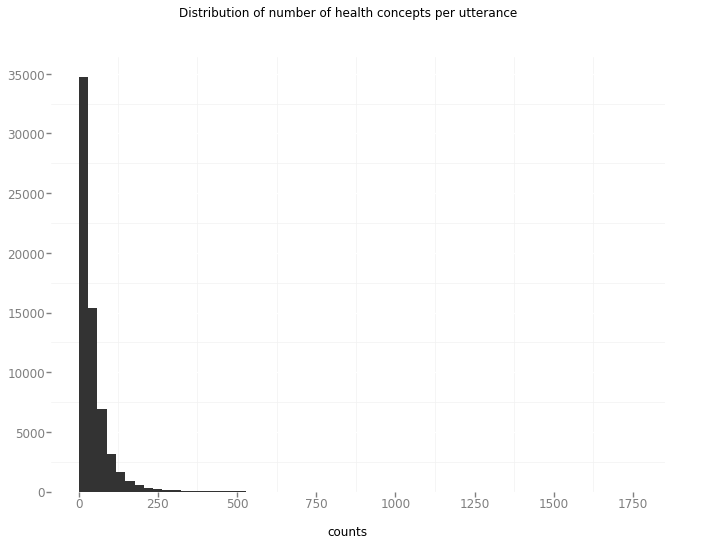

<ggplot: (507096945)>

In [148]:
from ggplot import *
concepts_counts_new_counts = [r[1] for r in concepts_counts_new]
df_t = pd.DataFrame(concepts_counts_new_counts)
df_t.columns = ['counts']

ggplot(df_t,aes(x='counts')) + geom_histogram(bins=60) + theme_bw() + ggtitle('Distribution of number of health concepts per utterance')

In [184]:
# retrieve mappings for groups on semtypes
df_semtypes = pd.read_csv('../data/semgroups.txt',sep='|')
df_semtypes.tail()

,ACTI,Activities & Behaviors,T052,Activity
127,PROC,Procedures,T058,Health Care Activity
128,PROC,Procedures,T059,Laboratory Procedure
129,PROC,Procedures,T063,Molecular Biology Research Technique
130,PROC,Procedures,T062,Research Activity
131,PROC,Procedures,T061,Therapeutic or Preventive Procedure


In [124]:
# map activity to activites & behaviors 
#activity = df_semtypes.apply(lambda row: {row['Activity']: row['Activities & Behaviors']} ,axis=1)
activity = dict(zip(df_semtypes['Activity'],df_semtypes['Activities & Behaviors']))
activity

{'Acquired Abnormality': 'Disorders',
 'Age Group': 'Living Beings',
 'Amino Acid Sequence': 'Genes & Molecular Sequences',
 'Amino Acid, Peptide, or Protein': 'Chemicals & Drugs',
 'Amphibian': 'Living Beings',
 'Anatomical Abnormality': 'Disorders',
 'Anatomical Structure': 'Anatomy',
 'Animal': 'Living Beings',
 'Antibiotic': 'Chemicals & Drugs',
 'Archaeon': 'Living Beings',
 'Bacterium': 'Living Beings',
 'Behavior': 'Activities & Behaviors',
 'Biologic Function': 'Phenomena',
 'Biologically Active Substance': 'Chemicals & Drugs',
 'Biomedical Occupation or Discipline': 'Occupations',
 'Biomedical or Dental Material': 'Chemicals & Drugs',
 'Bird': 'Living Beings',
 'Body Location or Region': 'Anatomy',
 'Body Part, Organ, or Organ Component': 'Anatomy',
 'Body Space or Junction': 'Anatomy',
 'Body Substance': 'Anatomy',
 'Body System': 'Anatomy',
 'Carbohydrate': 'Chemicals & Drugs',
 'Carbohydrate Sequence': 'Genes & Molecular Sequences',
 'Cell': 'Anatomy',
 'Cell Component': 'A

### Example for presentation

In [183]:
example = all_chats[98]
#common_concepts(example[0])
tags = tag_utterances(1, str(example[0]), tagger)
tags[:5]

[[1, 42, 62, 'persistent dry cough', 'C0857172', 1.0, {'Sign or Symptom'}],
 [1,
  318,
  334,
  'dextromethorphan',
  'C0011816',
  1.0,
  {'Clinical Drug', 'Organic Chemical', 'Pharmacologic Substance'}],
 [1,
  364,
  375,
  'benzonatate',
  'C0053229',
  1.0,
  {'Organic Chemical', 'Pharmacologic Substance'}],
 [1,
  380,
  391,
  'hydrocodone',
  'C0020264',
  1.0,
  {'Laboratory Procedure', 'Organic Chemical', 'Pharmacologic Substance'}],
 [1, 353, 363, 'prescribed', 'C0278329', 1.0, {'Health Care Activity'}],
 [1, 239, 248, 'sensitive', 'C0020517', 1.0, {'Pathologic Function'}],
 [1,
  655,
  664,
  'temporary',
  'C3245481',
  1.0,
  {'Body Location or Region', 'Intellectual Product'}],
 [1, 665, 673, 'inhalers', 'C0021461', 1.0, {'Medical Device'}],
 [1, 723, 731, 'possible', 'C0332149', 1.0, {'Finding'}],
 [1,
  300,
  307,
  'counter',
  'C1705206',
  1.0,
  {'Health Care Activity', 'Medical Device'}],
 [1,
  761,
  768,
  'inhaler',
  'C0021461',
  1.0,
  {'Medical Device',

In [150]:
behaviors = []
for utterance, _ in concepts_counts_new:
    behavior_utterance = []
    for concept in utterance:
        try:
            behavior_utterance.append(activity[concept])
        except:
            continue
    behaviors.append((behavior_utterance,len(behavior_utterance),len(list(set(behavior_utterance)))))

In [165]:
concepts_counts_new_counts = []
for rs in behaviors:
    concepts_counts_new_counts.append(rs[2])

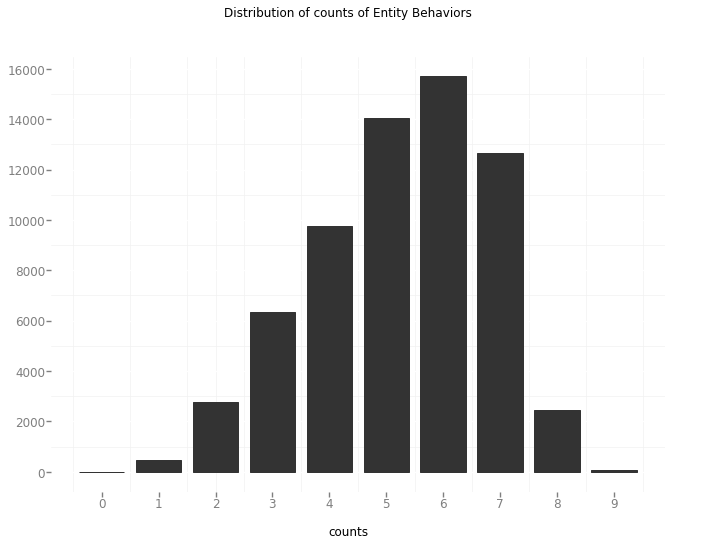

<ggplot: (563144091)>

In [168]:
df_t = pd.DataFrame(concepts_counts_new_counts)
df_t.columns = ['counts']

ggplot(df_t,aes(x='counts')) + geom_bar() + theme_bw() + ggtitle('Distribution of counts of Entity Behaviors')

In [197]:
# behaviors[0]
t1 = dict(Counter(behaviors[0][0]))
t2 = dict(Counter(behaviors[1][0]))

pd.DataFrame([t1,t2])

,Anatomy,Chemicals & Drugs,Concepts & Ideas,Devices,Disorders,Physiology,Procedures
0,10,77.0,84,19.0,133,50,66
1,2,NaN,5,NaN,12,2,4


In [198]:
from collections import Counter
# create a dataframe of counts of health behaviors by utterance
behavior_list = []
for b in behaviors:
    behavior_list.append(Counter(b[0]))

In [202]:
b[0]

['Disorders',
 'Anatomy',
 'Chemicals & Drugs',
 'Concepts & Ideas',
 'Chemicals & Drugs',
 'Disorders',
 'Chemicals & Drugs',
 'Chemicals & Drugs',
 'Chemicals & Drugs']

In [203]:
len(behaviors)

64233

In [207]:
df_behaviors = pd.DataFrame(behavior_list)
df_behaviors.to_csv('../data/behavior_df.csv',index=False)

In [84]:
pickle.dump(q_concepts,open('../data/q_concepts.pickle','wb'))
pickle.dump(concepts_counts_new,open('../data/concepts_counts.pickle','wb'))

In [75]:
len(concepts_counts)

96112

In [14]:
# average number of concepts per utterance pair
count / len(all_chats)

19.246795405360412

#### UMLS tagging for original utterances

In [25]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from processing import DataPipeline
pd.set_option('display.max_columns', 500) # more columns displayed at once

# Set path for importing data
data_instance = DataPipeline(comments_path = '../data/reddit_comments_askDocs_2014_to_2018_03.gz',
                            posts_path = '../data/original_posts_under_askDocs_subreddit_id.gz')
df = data_instance.load_full_thread()

Comments Table Shape: (557648, 24)
Posts table shape: (43615, 35)
30710
Final combined table shape: (139535, 28)


In [ ]:
initial_q = df[df['is_thread_start'] == 1]['body'].apply(lambda r: str(r))
thread_concepts = []
for thread in tqdm.tqdm(initial_q):
    thread_concepts += common_concepts(thread)

 29%|██▉       | 8852/30710 [20:37<50:56,  7.15it/s]  

In [46]:
from nltk import word_tokenize
import nltk
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
nltk.download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')
nltk.download('punkt')  # Download data for tokenizer.

def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    return doc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austinpowell/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austinpowell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
import gensim
model = gensim.models.Word2Vec(thread_concepts, workers=3, size=100)

from gensim.similarities import WmdSimilarity
num_best = 10
instance = WmdSimilarity(thread_concepts, model, num_best=10)

In [61]:
%time
sentence = "Hey, how's your husband doing now? Hope everything is okay"
query = preprocess(sentence)
sims = instance[sentence]
sims


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


[(489770, 0.685390297758631),
 (143718, 0.685390297758631),
 (395058, 0.685390297758631),
 (677616, 0.685390297758631),
 (1062694, 0.685390297758631),
 (976900, 0.685390297758631),
 (634355, 0.685390297758631),
 (1031080, 0.685390297758631),
 (1017620, 0.685390297758631),
 (153039, 0.685390297758631)]

In [47]:
import time
start = time.time()

sent = 'Very good, you should seat outdoor.'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print ('Cell took %.2f seconds to run.' %(time.time() - start))

Cell took 32.72 seconds to run.


In [48]:
# Print the query and the retrieved documents, together with their similarities.
print ('Query:')
print (sent)
for i in range(num_best):
    print()
    print ('sim = %.4f' % sims[i][1])
    print (documents[sims[i][0]])

Query:
Very good, you should seat outdoor.



IndexError: list index out of range